In [9]:
from functions import *


In [10]:
###  Inputs



# La ruta al Weather debe ser correcta
ruta_archivo = '../Weather.csv'

# Cargar el archivo
Weather = pd.read_csv(ruta_archivo)

i = 0  # fila i del archivo Weather
wdfh = Weather.iloc[i]  # seleccionando una fila en formato DataFrame

ftype = "C1"  # Ejemplo de tipo de combustible

# Ejemplo de cálculo de jd, lat, long, etc. (ajustar según el formato real de tus datos)
jd = (pd.to_datetime(wdfh['datetime']) - pd.to_datetime("01-Jan-2001")).days
lat = 51.621244  # Ejemplo de latitud
long = -115.608378  # Ejemplo de longitud
elev = 2138.0  # Ejemplo de elevación geográfica
ps = 0  # Porcentaje de pendiente
saz = 0  # Azimut de la pendiente (dirección cuesta arriba)


In [11]:
# Cálculos

# Consumo de combustible superficial
sfc = surf_fuel_consump(ftype, wdfh, FuelConst2)  # en [Kg/m2]

# Tasa de propagación de la cabeza del incendio (HROS = ROS) (incluye efecto de pendiente y acumulación)
ros, wsv, raz, isi = rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q)  # [m/min]

# Intensidad del fuego superficial
sfi = fire_intensity(sfc, ros)  # en [kW/m]

# Contenido de humedad foliar
fmc = foliar_moisture(lat, long, elev, jd)  # en [%]

# Intensidad crítica de la superficie
csi = crit_surf_intensity(CBH[ftype], fmc)

# Determinar el tipo de fuego y realizar cálculos adicionales
if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):  # CBH > 0
    # Tipo de fuego = corona
    if sfi > csi:
        rso = max(csi / (300 * sfc), 0.0)  # Tasa crítica de propagación
        cfb = max(1 - math.exp(-0.23 * (ros - rso)), 0.0)  # Fracción de la corona quemada
        cfc = CFL[ftype] * cfb  # Consumo de combustible de la corona
        if ftype in ["M1", "M2"]:
            cfc *= FuelConst2["pc"] / 100.0  # actualización
        elif ftype in ["M3", "M4"]:
            cfc *= FuelConst2["pdf"] / 100.0  # actualización
        tfc = sfc + cfc
        ros = final_ros(ftype, fmc, isi, cfb, ros)
        fi = fire_intensity(tfc, ros)  # Intensidad total del fuego
        firetype = "crown"
    else:
        cfb = 0
        cfc = 0
        tfc = sfc
        fi = sfi
else:  # CBH == 0.0
    cfb = 0
    cfc = 0
    tfc = sfc
    fi = sfi

# Efecto FFMC
ffmc = wdfh["FFMC"]
ff = ffmc_effect(ffmc)

# Relación longitud/ancho
lb = length2breadth(ftype, wsv)

# ISI de retroceso
bisi = backfire_isi(wsv, ff)

# Tasa de propagación de retroceso
brss = backfire_ros(ftype, bisi, wdfh, a, b, c, FuelConst2, bui0, q)

if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):
    bros, bfi, bfc, back_firetype = back_fire_behaviour(ftype, sfc, brss, csi, rso, fmc, bisi, CFL)

# Tasa de propagación lateral
fros = flankfire_ros(ros, bros, lb)

# Comportamiento del fuego lateral
ffi, ffc, flank_firetype = flank_fire_behaviour(ftype, sfc, fros, csi, rso, CFL)

# Tiempo transcurrido
elapsetime = 60  # [min]

# Aceleración
accn = acceleration(ftype, cfb)

# Distancia y tasa de propagación de la cabeza del incendio
hdist, hrost = spread_distance(ros, elapsetime, accn)

# Distancia y tasa de propagación de retroceso
bdist, brost = spread_distance(bros, elapsetime, accn)

# Distancia, tasa y longitud/ancho de propagación lateral
fdist, rost, lbt = flank_spread_distance(hrost, brost, hdist, bdist, lb, accn, elapsetime)

# Área del Elipse
areaelipse = area(hdist + bdist, fdist)

# Perímetro del Elipse
perelipse = perimeter(hdist, bdist, lb)

# Salidas Primarias
print('Primary Outputs:')
print(f'HROS_t = {hrost:.3f} [m/min]\t\tSFC = {sfc:.3f} [Kg/m2]')
print(f'HROS_eq = {ros:.3f} [m/min]\t\tCFC = {cfc:.3f} [Kg/m2]')
print(f'HFI = {fi:.3f} [kW/m]\t\tTFC = {tfc:.3f} [Kg/m2]')
print(f'CFB = {cfb * 100:.3f} [Percentage]\tFire description:  {firetype}-fire\n\n')

# Salidas Secundarias
print('Secondary Outputs:')
print(f'RSO = {rso:.3f} [m/min]\tCSI = {csi:.3f} [kW/m]\tDH = {hdist:.3f} [m]\tLB = {lb:.3f} [m]')
print(f'FROS = {fros:.3f} [m/min]\tFFI = {ffi:.3f} [kW/m]\tDF = {fdist:.3f} [m]\t\tArea = {areaelipse:.3f} [ha]')
print(f'BROS = {bros:.3f} [m/min]\tBFI = {bfi:.3f} [kW/m]\tDB = {bdist:.3f} [m]\t\tPerimeter = {perelipse:.3f} [m]')


Primary Outputs:
HROS_t = 6.083 [m/min]		SFC = 1.399 [Kg/m2]
HROS_eq = 6.089 [m/min]		CFC = 0.493 [Kg/m2]
HFI = 3455.373 [kW/m]		TFC = 1.892 [Kg/m2]
CFB = 65.702 [Percentage]	Fire description:  crown-fire


Secondary Outputs:
RSO = 1.436 [m/min]	CSI = 602.813 [kW/m]	DH = 312.445 [m]	LB = 2.695 [m]
FROS = 1.130 [m/min]	FFI = 474.228 [kW/m]	DF = 58.023 [m]		Area = 2.849 [ha]
BROS = 0.002 [m/min]	BFI = 0.811 [kW/m]	DB = 0.099 [m]		Perimeter = 708.525 [m]


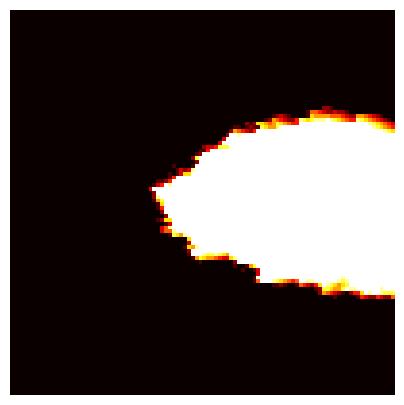

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# Función para actualizar el fuego en la cuadrícula
def update_fire(grid, hros_t, hros_eq, hfi, cfb):
    """
    Función que actualiza la propagación del fuego en la cuadrícula.

    Parámetros:
        grid (numpy.ndarray): Cuadrícula que representa el estado actual del fuego.
        hros_t (float): Velocidad de propagación del fuego (m/min).
        hros_eq (float): Velocidad de propagación del fuego equivalente (m/min).
        hfi (float): Intensidad de la propagación del fuego (kW/m).
        cfb (float): Porcentaje de velocidad de propagación del fuego.

    Retorna:
        numpy.ndarray: Nueva cuadrícula con el estado actualizado del fuego.
    """
    new_grid = np.copy(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] > 0:  # Si hay fuego en esta celda
                # Ajustar los parámetros de propagación según las funciones dadas
                hros_prob = hros_eq / 10  # Normalizamos HROS_eq para que esté en el rango de 0 a 1
                hfi_factor = hfi / 1000  # Normalizamos HFI para que esté en el rango de 0 a 1
                # Modificamos la probabilidad de propagación en la cabeza del fuego
                hros_prob *= (cfb / 100)  # Ajustamos la probabilidad en función de cfb
                # Modificamos la probabilidad de propagación en función de hfi
                hros_prob *= (1 + hfi_factor)  # Incrementa la probabilidad en función de HFI Factor
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if 0 <= i + di < grid.shape[0] and 0 <= j + dj < grid.shape[1]:
                            if di == 0 and dj == 1:  # Hacia la derecha (cabeza del fuego)
                                prob = hros_prob
                            elif di in [-1, 1] or dj in [-1, 1]:  # Diagonal y flancos
                                prob = fros_prob
                            else:  # Hacia atrás y la propia celda
                                prob = bros_prob
                            if np.random.rand() < prob:
                                new_grid[i + di, j + dj] = min(10, grid[i + di, j + dj] + 1)  # Incrementa la intensidad del fuego
    return new_grid


# Configuración inicial
grid_size = 100
fire_grid = np.zeros((grid_size, grid_size))
start_point = grid_size // 2
fire_grid[start_point, start_point] = 1  # Inicia el fuego en el centro

# Parámetros de propagación (simplificados)
fros_prob = 0.02  # Probabilidad de propagación en los flancos
bros_prob = 0.05  # Probabilidad de propagación en el retroceso

# Parámetros secundarios
hros_t = 6.083  # [m/min]
hros_eq = 6.089  # [m/min]
hfi = 3455.373  # [kW/m]
cfb = 65.702  # [Percentage]

# Configuración de la animación
fig, ax = plt.subplots(figsize=(5, 5))

# Función de inicialización para la animación
def init():
    """
    Función de inicialización para la animación.
    Limpia el eje y muestra la cuadrícula inicial del fuego.
    """
    ax.clear()
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)  # Asigna la intensidad del fuego de 0 a 10
    plt.axis('off')

# Función de actualización para la animación
def update(frame):
    """
    Función de actualización para la animación.
    Actualiza el estado del fuego en cada frame de la animación.
    """
    global fire_grid
    ax.clear()
    fire_grid = update_fire(fire_grid, hros_t, hros_eq, hfi, cfb)
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)
    plt.axis('off')

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=100, init_func=init, blit=False, interval=100, repeat=False)

# Mostrar la animación
HTML(ani.to_jshtml())